<font size=+2>**Alternative Time series Models**</font>

- Prophet
- VARMA model

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Prophet" data-toc-modified-id="Prophet-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prophet</a></span></li>
        <li><span><a href="#VARMA" data-toc-modified-id="VARMA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>VARMA</a></span></li>
    </ul>
</div>

In [1]:
# Import libraries and set parameters 

import warnings; 
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore",category=UserWarning)
warnings.simplefilter(action="ignore",category=FutureWarning)

import matplotlib.pyplot as plt
#plt.style.use('ggplot')
# plt.style.use('seaborn-muted')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['grid.linestyle'] = ':'   
plt.rcParams['axes.grid'] = True

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
#sns.color_palette("RdBu", n_colors=10)

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)
print('Seaborn version', sns.__version__)

Numpy version 1.26.4
Pandas version 2.2.2
Seaborn version 0.13.2


In [2]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def get_forecast_accuracy(y, y_hat):
    # ME
    me = (y - y_hat).sum()/len(y)

    # RMSE
    rmse = math.sqrt(mean_squared_error(y, y_hat))

    # MAPE
    mape = mean_absolute_percentage_error(y, y_hat) * 100
    
    # WAPE
    wape = (y - y_hat).__abs__().sum() / y.__abs__().sum() * 100

    print("ME: %.2f, RMSE: %.2f, MAPE: %.2f%%, WAPE: %.2f%%" % (me,rmse,mape,wape))

## Prophet

In [3]:
# read data from NY times
df = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv")
df.head()
df.info()


,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158 entries, 0 to 1157
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1158 non-null   object
 1   cases   1158 non-null   int64 
 2   deaths  1158 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 27.3+ KB


**Dataframe must have columns "ds" and "y" with the dates and values respectively**

In [4]:
# engineer new cases
df['new_cases'] = df.cases - df.cases.shift().fillna(0)

# Create pandas time series with date labels correctly shown. 
df.date = pd.to_datetime(df.date)
df.set_index('date',inplace=True)
#df['rolling_weekly_avg'] = df.new_cases.rolling(window=7).mean().fillna(0)

# create timeseries readable by fbprophet
ts = pd.DataFrame({'ds':df.index,'y':df.new_cases})

# Need to have bounds if using logistc growth. Unused for linear growth.
#ts['cap'] = 3000000
#ts['floor'] = 0 

ts.describe()

,ds,y
count,1158,1.158000e+03
mean,2021-08-21 12:00:00,8.973233e+04
min,2020-01-21 00:00:00,-2.399900e+04
25%,2020-11-05 06:00:00,2.457425e+04
50%,2021-08-21 12:00:00,5.424750e+04
75%,2022-06-06 18:00:00,1.164220e+05
max,2023-03-23 00:00:00,1.433977e+06
std,NaN,1.280600e+05


In [5]:
ts.tail(2)
ts.info()

,ds,y
date,,
2023-03-22,2023-03-22,51812.0
2023-03-23,2023-03-23,45146.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1158 entries, 2020-01-21 to 2023-03-23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1158 non-null   datetime64[ns]
 1   y       1158 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 27.1 KB


<Axes: xlabel='date'>

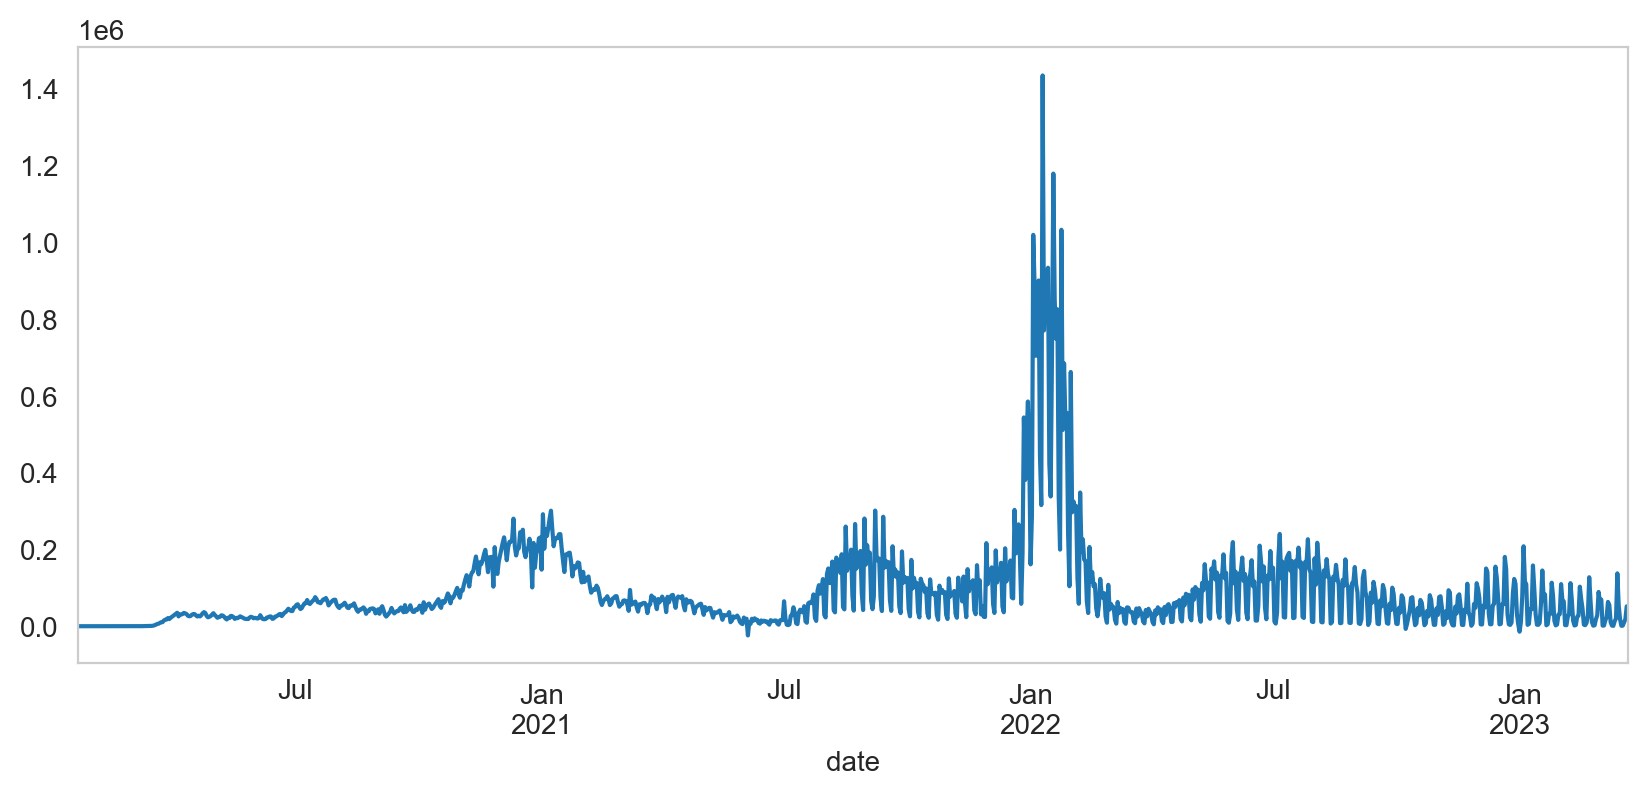

In [6]:
ts['y'].plot(figsize=(10,4))

Changepoints can be manually specified as ``changepoints=['2014-01-01']``

07:48:39 - cmdstanpy - INFO - Chain [1] start processing
07:48:39 - cmdstanpy - INFO - Chain [1] done processing


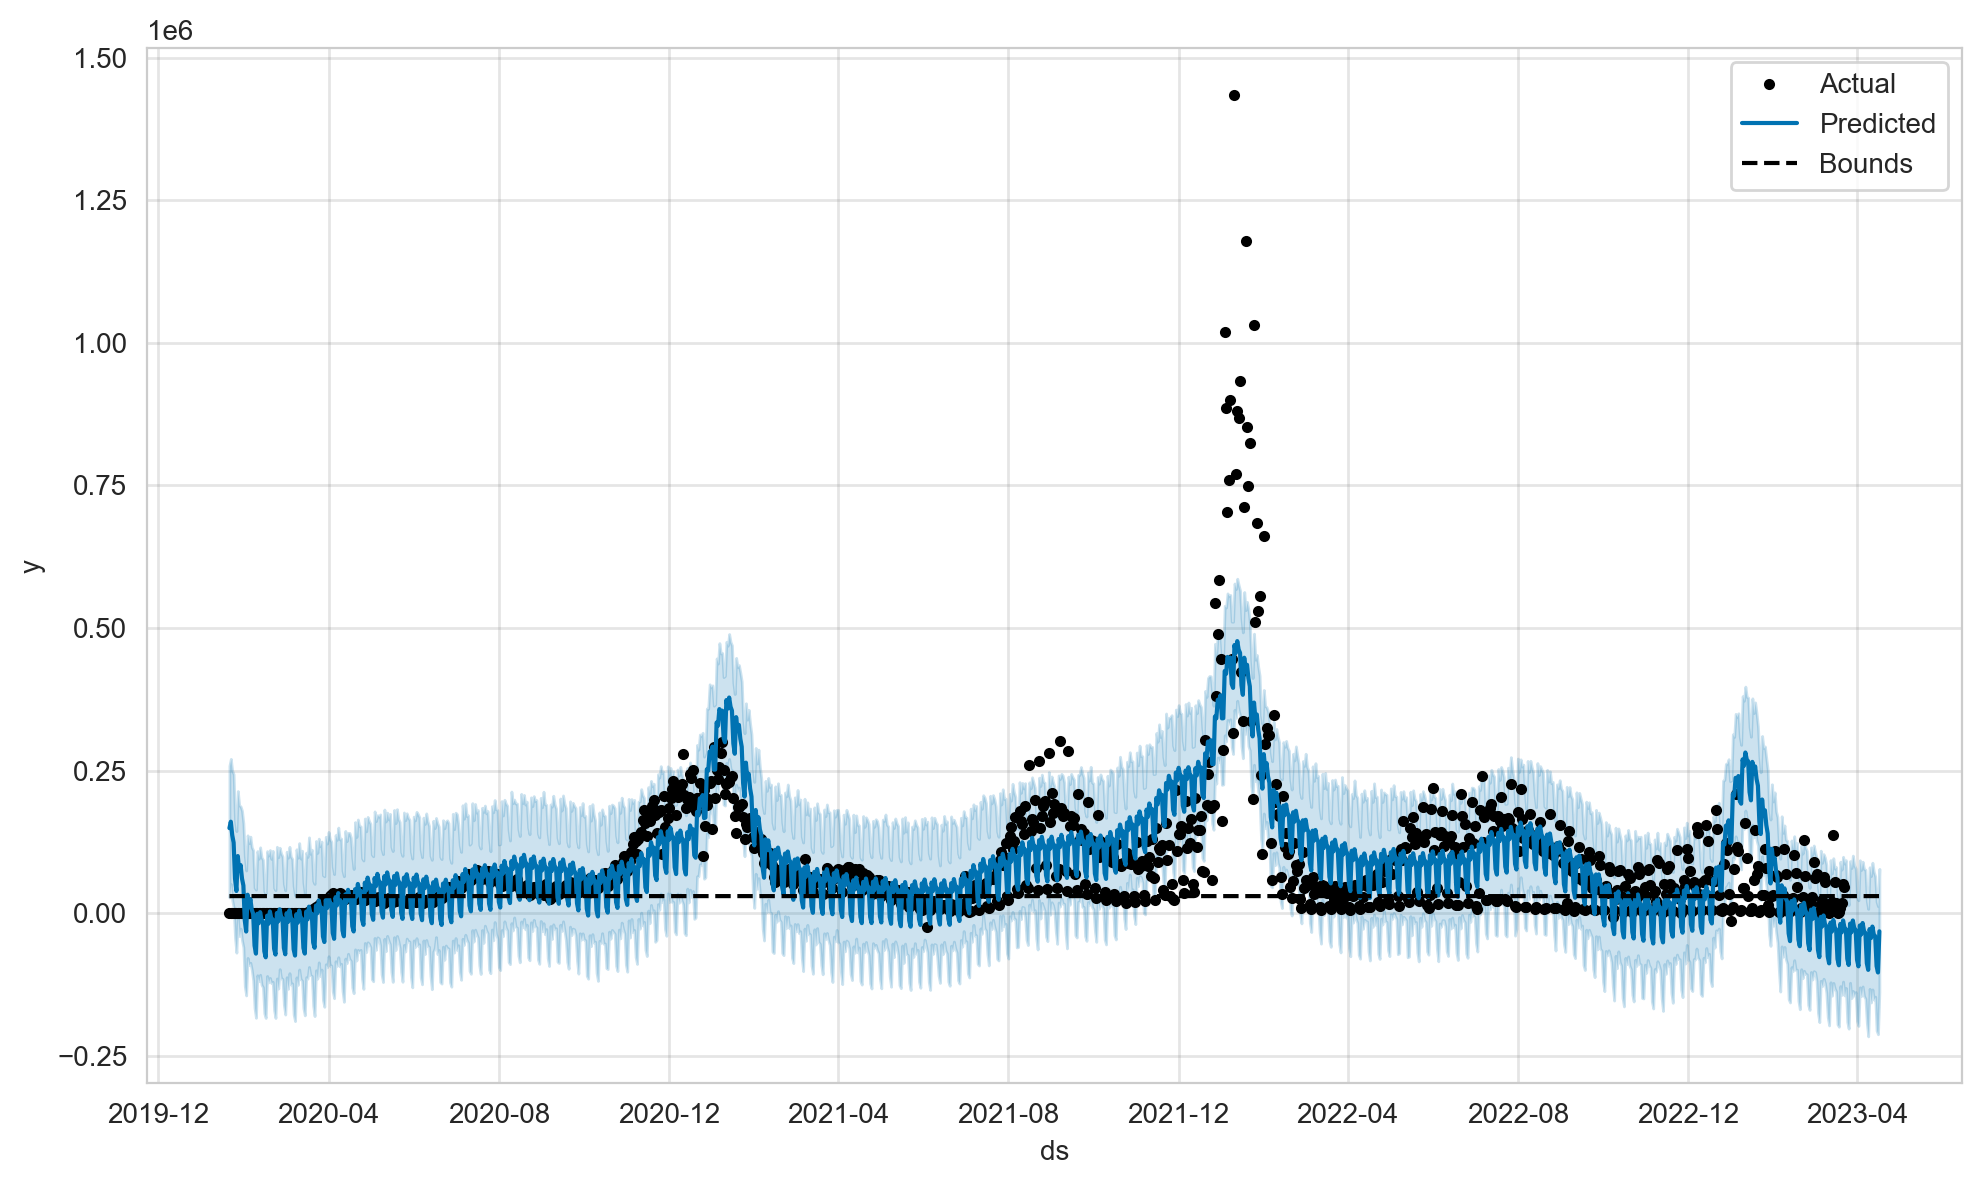

In [7]:
from prophet import Prophet

# instantiate the model and fit the timeseries
prophet = Prophet(yearly_seasonality=True, 
                  daily_seasonality=True, 
                  weekly_seasonality=True,
                  growth='linear',
                  n_changepoints= 10,
                  changepoint_range=1, # Consider the whole range for change points
                  changepoint_prior_scale=0.4) # Adjust trend flexibility if it overfits (too large) or underfits (too small).
                                               # Higher value = More flexible trend
prophet.fit(ts)

# Create additional points 25 periods into a future data frame 
future = prophet.make_future_dataframe(periods=25)
future['cap'] = 30000
future['floor'] = 0 
forecast = prophet.predict(future)

# plot
fig = prophet.plot(forecast)
ax = fig.gca()  # Now you have the matplotlib Axis
ax.legend(['Actual','Predicted','Bounds'])  
pass; 

In [8]:
# display the most critical output columns from the forecast
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-21,149180.316474,27480.797569,258657.933824
1,2020-01-22,160420.336359,51140.637299,270662.554348
2,2020-01-23,136970.658013,22885.442886,249655.366636
3,2020-01-24,123909.305336,10033.915764,243605.741836
4,2020-01-25,60968.513665,-43130.700108,161893.923298


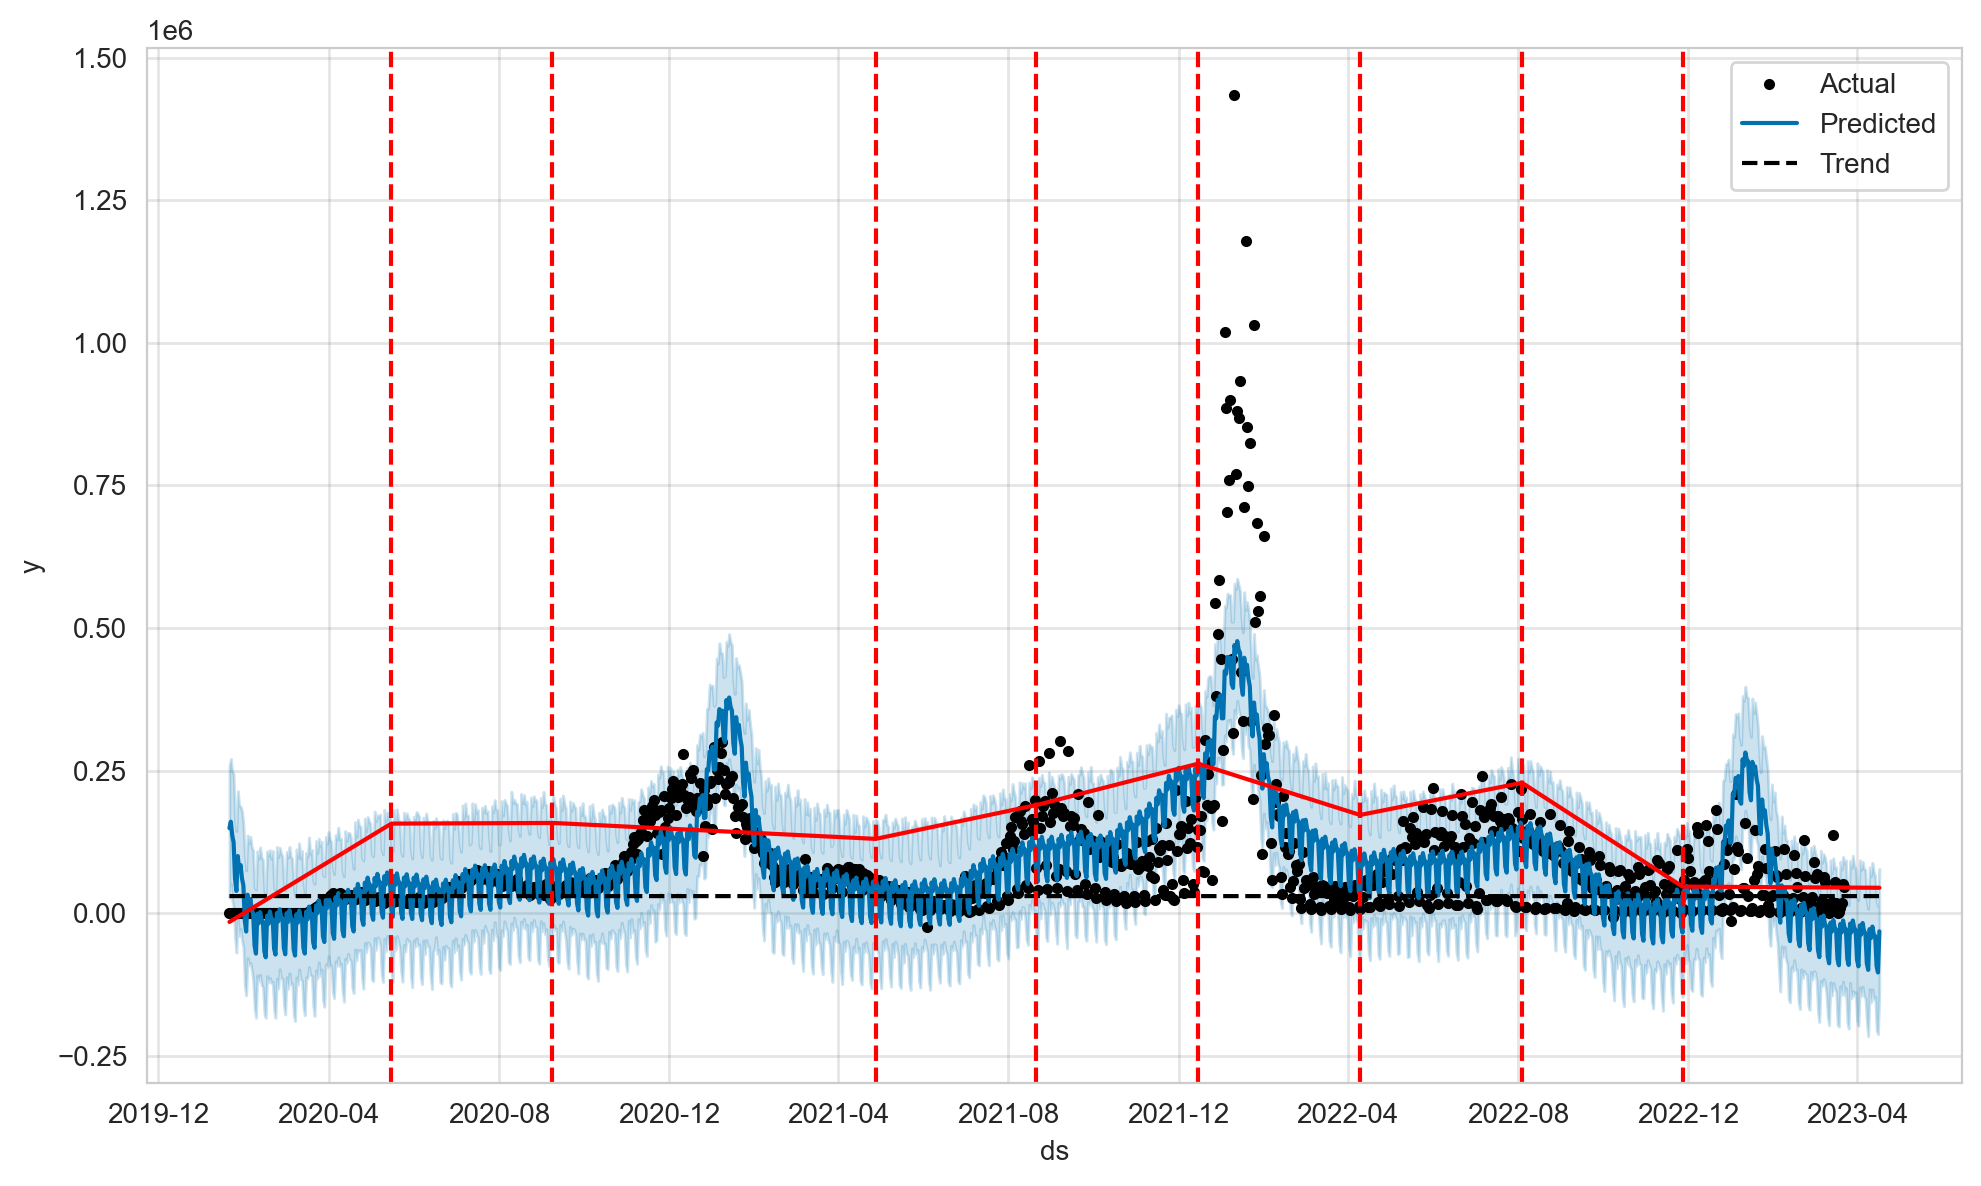

In [9]:
from prophet.plot import add_changepoints_to_plot

fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

ax = fig.gca()  # Now you have the matplotlib Axis
ax.legend(['Actual','Predicted','Trend'])  

## VARMA

### Load data

In [3]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [9]:
uscon = pd.read_excel('data/ts-datasets.xlsx', sheet_name='USCON', header=0, index_col=0, parse_dates=True)
uscon.head()

,Consumption,Income,Production,Savings,Unemployment
YearQ,,,,,
1960-01-01,0.947824,1.182498,5.854556,3.183293,0.1
1960-04-01,1.260476,0.625615,-2.193661,-4.813764,0.0
1960-07-01,-0.400781,0.176703,-1.658109,5.334598,0.1
1960-10-01,0.126736,-0.041823,-2.440186,-1.307208,1.1
1961-01-01,-0.026390,0.966727,-1.525517,9.291497,0.3


In [10]:
uscon = uscon.resample('QS-JAN').asfreq()

### Find best order to fit k_AR_diff

In [11]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(uscon)
print(model.select_order())

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 3, BIC -> 1, FPE -> 3, HQIC ->  1>


### ADFuller Test

In [12]:
from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is trend stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is stostochastic trend")

In [13]:
for name, column in uscon.items():
    Augmented_Dickey_Fuller_Test_func(uscon[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Consumption
Test Statistic                  -5.200627
p-value                          0.000009
No Lags Used                     2.000000
Number of Observations Used    224.000000
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is trend stationary


Results of Dickey-Fuller Test for column: Income
Test Statistic                -9.540832e+00
p-value                        2.729581e-16
No Lags Used                   1.000000e+00
Number of Observations Used    2.250000e+02
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is trend stationary


Results of Dickey-Fuller Test for column: Production
Test Statistic                  -4.685825
p-value                          0.000089
No Lags Used                    11.000000
Number of Observations Used    215.000000
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is trend stationary


Results of Dickey-Fuller Test for column: Savings
Test Statistic          

### Test for Cointegration

In [14]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df): 
    res = coint_johansen(df,0,3)
    traces = res.lr1        # statistical test values
    cvts = res.cvt[:,1]     # critical value at 95% CI
    print('Column Name > Test Stat > C(95%) => Significant')
    print('----------------------------------------------')
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(col, '>', round(trace,2), ">", round(cvt,2), '=>' , trace > cvt)

In [15]:
cointegration_test(uscon)

Column Name > Test Stat > C(95%) => Significant
----------------------------------------------
Consumption > 278.46 > 69.82 => True
Income > 190.37 > 47.85 => True
Production > 112.64 > 29.8 => True
Savings > 54.35 > 15.49 => True
Unemployment > 22.15 > 3.84 => True


### Split the data set 

In [16]:
split_ratio = 0.7
train_size = int(len(uscon)*split_ratio)
Y_train, Y_test = uscon[:train_size], uscon[train_size:]

### Grid search VARMA

In [17]:
import itertools

def grid_search_VARMA(Y_train, max_p, max_q):

    results = []

    pq = np.arange(max_p+1), np.arange(max_q+1) 

    for p, q in itertools.product(*pq):
        order = (p, q)
        if order != (0, 0):
            model = VARMAX(Y_train, order=order)
            model_fit = model.fit(disp=False)
            error = model_fit.aicc
            results.append((order, error))
            print(f'VARMAX{order} - AICC:{error}')

    return results

In [18]:
results = grid_search_VARMA(Y_train,3,3)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(0, 1) - AICC:1982.8641799080124


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(0, 2) - AICC:2059.911289688543


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(0, 3) - AICC:2249.4482931187213


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(1, 0) - AICC:1966.4352170239638


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(1, 1) - AICC:2059.2162753309644


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(1, 2) - AICC:2257.187063977631


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(1, 3) - AICC:2756.218238342416


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(2, 0) - AICC:2042.1998415935452


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(2, 1) - AICC:2260.691648135774


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(2, 2) - AICC:2770.309067978609


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(2, 3) - AICC:5532.785871075452


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(3, 0) - AICC:2231.0440130697957


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(3, 1) - AICC:2755.2264008887296


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(3, 2) - AICC:5530.808122888395


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


VARMAX(3, 3) - AICC:inf


In [25]:
results.info()

AttributeError: 'list' object has no attribute 'info'

In [19]:
# Print top 10 best models
print("\nTop 10 best VARMAX configurations:")
for i, (order, error) in enumerate(sorted(results, key=lambda x: x[1])[:10]):
    print(f'{i+1}: VARMAX{order} - AICC:{error}')


Top 10 best VARMAX configurations:
1: VARMAX(1, 0) - AICC:1966.4352170239638
2: VARMAX(0, 1) - AICC:1982.8641799080124
3: VARMAX(2, 0) - AICC:2042.1998415935452
4: VARMAX(1, 1) - AICC:2059.2162753309644
5: VARMAX(0, 2) - AICC:2059.911289688543
6: VARMAX(3, 0) - AICC:2231.0440130697957
7: VARMAX(0, 3) - AICC:2249.4482931187213
8: VARMAX(1, 2) - AICC:2257.187063977631
9: VARMAX(2, 1) - AICC:2260.691648135774
10: VARMAX(3, 1) - AICC:2755.2264008887296


### Fit best model

In [20]:
best_pq = (0,3)

model = VARMAX(Y_train, order=best_pq, trend='c').fit(disp=False)
model.summary()

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['Consumption', 'Income', 'Production', 'Savings', 'Unemployment']",No. Observations:,158
Model:,VMA(3),Log Likelihood,-882.627
,+ intercept,AIC,1955.255
Date:,"Thu, 25 Jul 2024",BIC,2246.201
Time:,08:05:43,HQIC,2073.412
Sample:,01-01-1960,,
,- 04-01-1999,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.53, 0.02, 4.16, 0.76, 0.12",Jarque-Bera (JB):,"30.19, 32.99, 17.04, 192.95, 0.66"
Prob(Q):,"0.47, 0.89, 0.04, 0.38, 0.72",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.72"
Heteroskedasticity (H):,"0.58, 0.65, 0.29, 6.32, 0.92",Skew:,"-0.60, 0.29, -0.21, -0.68, 0.07"


In [26]:
model.forecast(5)

,Consumption,Income,Production,Savings,Unemployment
1999-07-01,0.869471,1.373993,0.917776,7.720125,-0.330325
1999-10-01,0.834260,1.217336,1.110979,3.080136,0.025320
2000-01-01,1.438528,1.281541,1.358631,-1.006563,-0.292892
2000-04-01,0.912660,0.887089,0.890256,1.316714,-0.014466
2000-07-01,0.912660,0.887089,0.890256,1.316714,-0.014466


### Fitted values

<Figure size 1000x400 with 0 Axes>

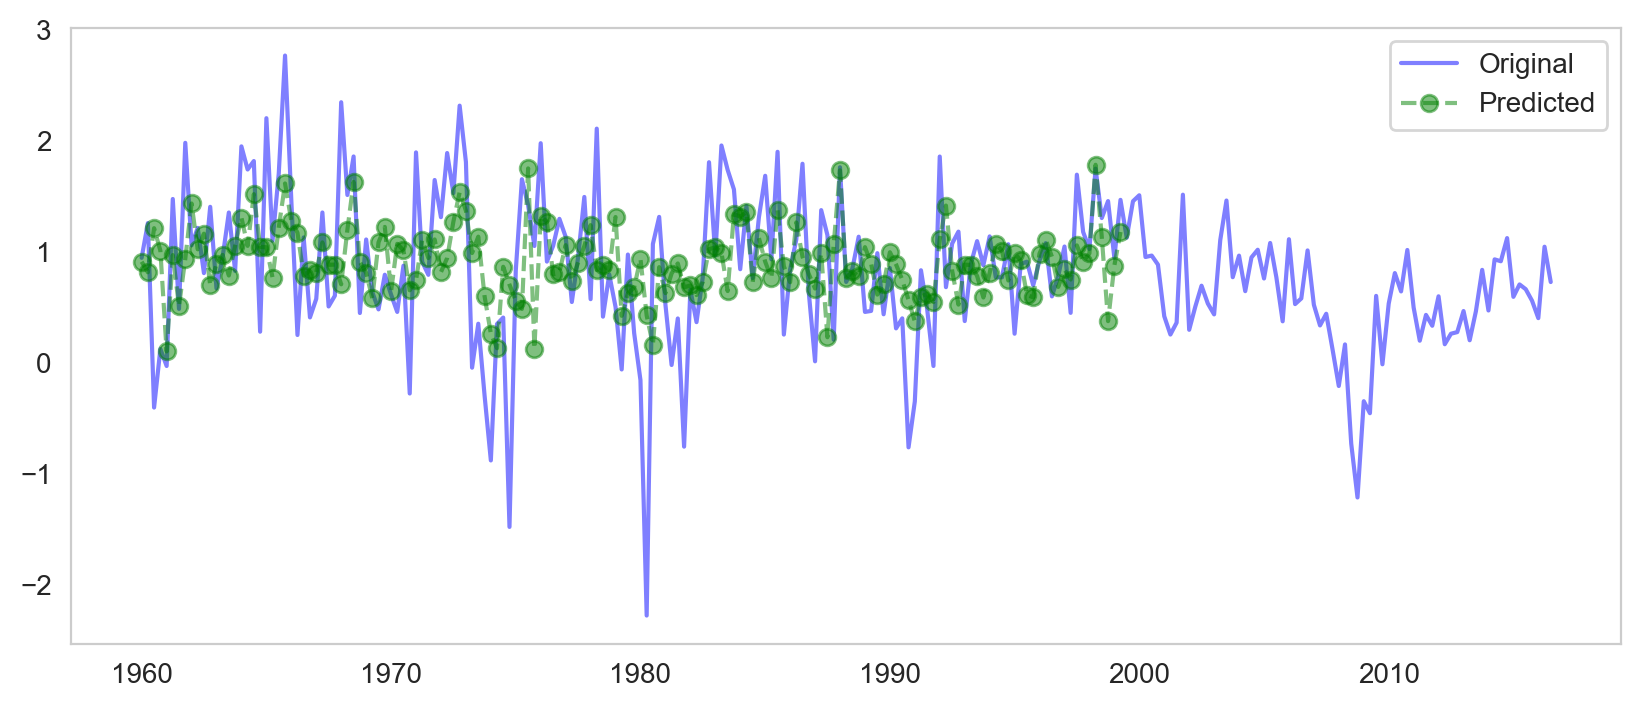

ME: -0.01, RMSE: 0.64, MAPE: 163.02%, WAPE: 48.78%


In [22]:
plt.figure(figsize=(10,4))
plt.plot(uscon['Consumption'], alpha=0.5, color='blue', label='Original')
plt.plot(model.predict()['Consumption'], marker='o', linestyle='--', alpha=0.5, color='green', label='Predicted')
plt.legend()
plt.show()

get_forecast_accuracy(Y_train['Consumption'], model.predict()['Consumption'])

### Rolling-forward CV for h-step ahead forecast

In [ ]:
history = [y for y in Y_train.values]
train = history
predictions = list()
upper_ci = list()
lower_ci = list()


h = 1
for t in range(len(Y_test)-(h-1)):
      
  model_fit = VARMAX(train, order=best_pq).fit(disp=False)
    
  output = model_fit.get_forecast(h)
  predictions.append(output.predicted_mean[h-1])
  lower_ci.append(output.conf_int()[h-1, 0])
  upper_ci.append(output.conf_int()[h-1, 5])

  history.append(Y_test.iloc[t])
  train = history[t+1:]

<Figure size 800x400 with 0 Axes>

ME: -0.17, RMSE: 0.46, MAPE: 140.38%, WAPE: 53.14%


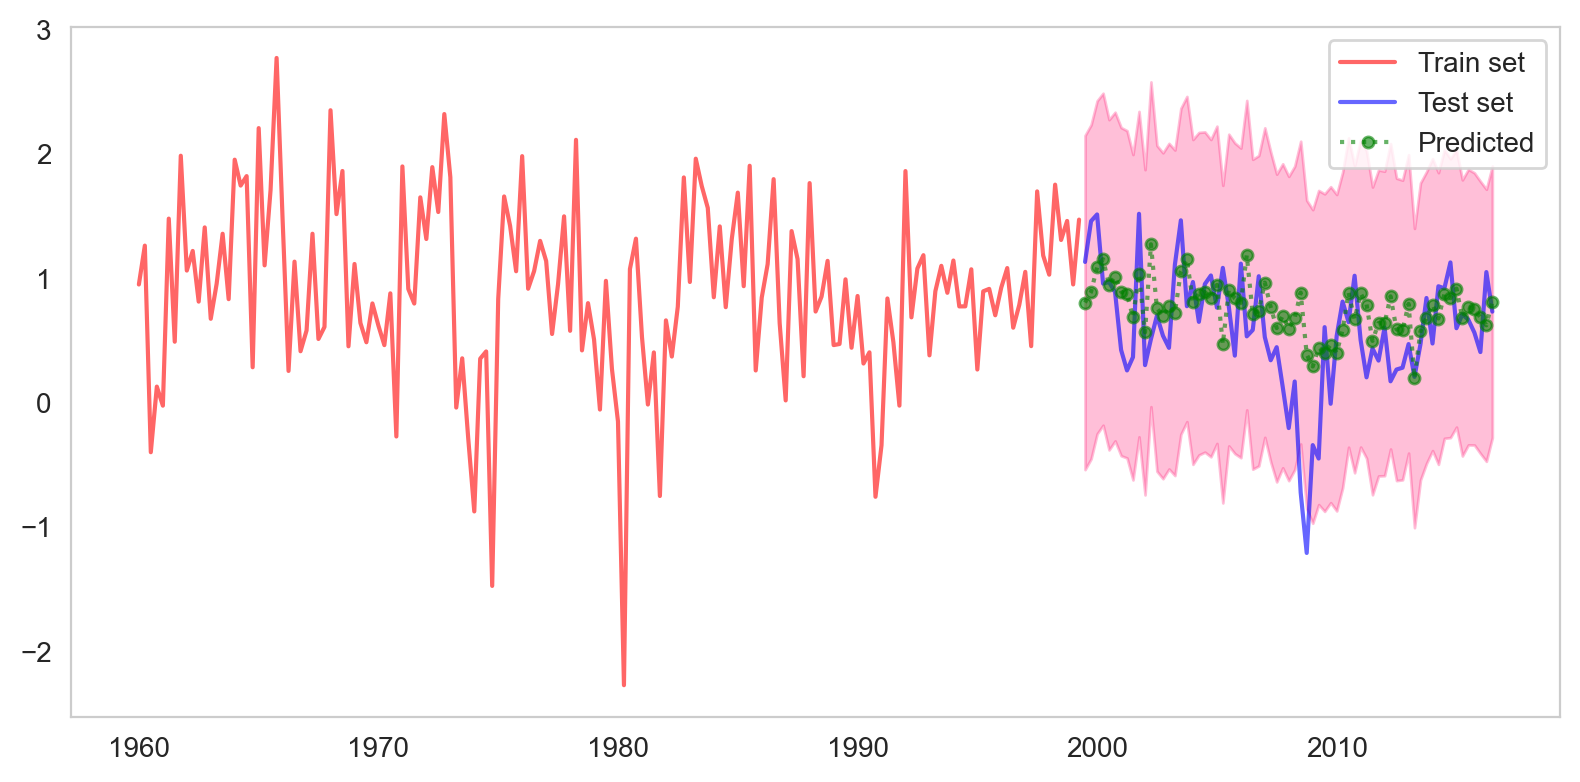

In [112]:
plt.figure(figsize=(8,4))
plt.plot(Y_train['Consumption'], label='Train set', color='red', alpha=0.6); 
plt.plot(Y_test['Consumption'], label='Test set', color='blue', alpha=0.6); 

predictions_con = pd.Series([i[0] for i in predictions], index=Y_test.index[h-1:])
plt.plot(predictions_con, 'go:', label='Predicted', alpha=0.6, ms=4) 
plt.fill_between(Y_test.index[h-1:], upper_ci, lower_ci, color='#ff0066', alpha=.25)
plt.legend(loc='best')
plt.tight_layout();

get_forecast_accuracy(Y_test['Consumption'][h-1:], predictions_con)

### Out of sample forecast

<Figure size 1000x400 with 0 Axes>

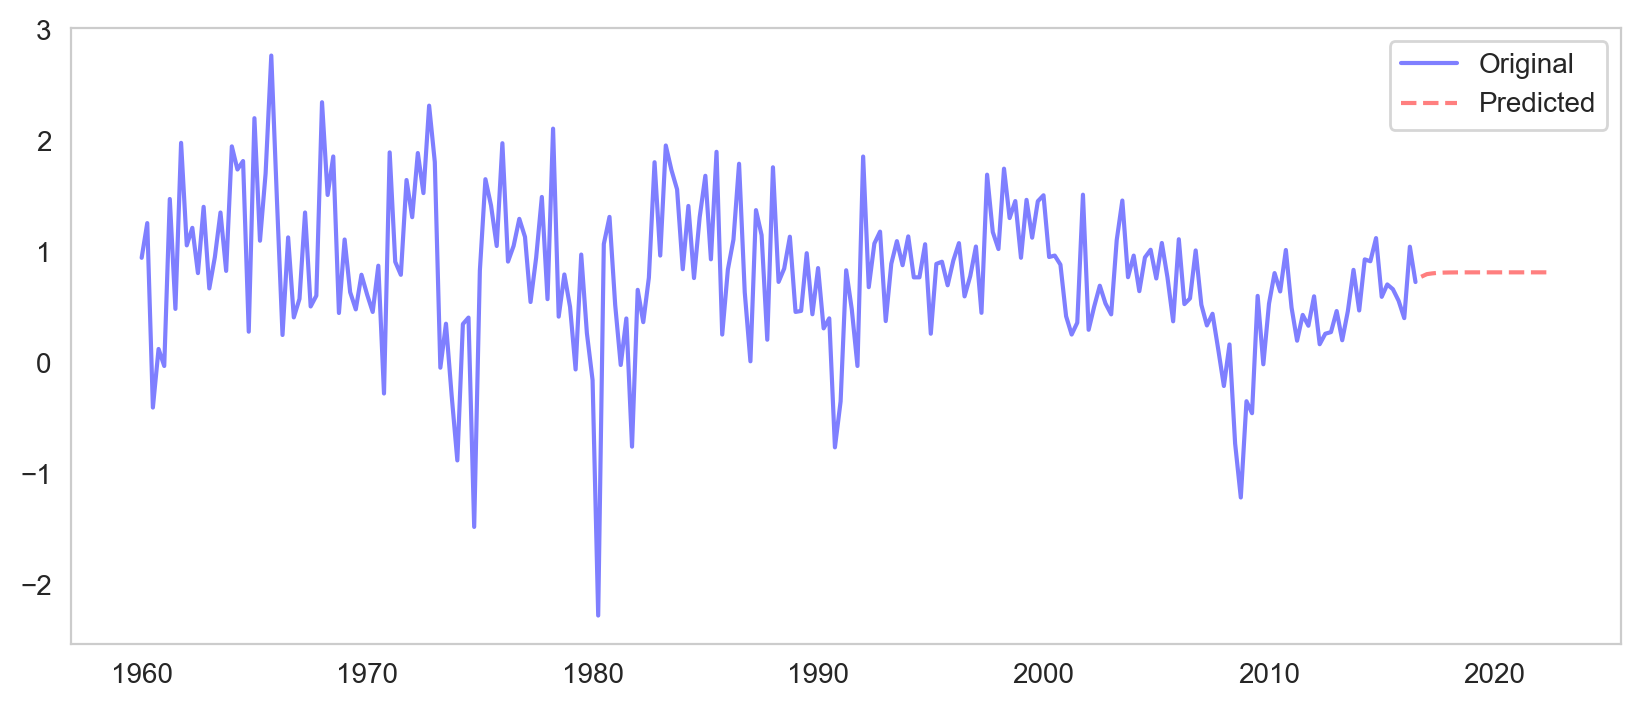

In [94]:
h = 24

results = model.forecast(h)

plt.figure(figsize=(10,4))
plt.plot(uscon['Consumption'], alpha=0.5, color='blue', label='Original')
plt.plot(results['Consumption'], linestyle='--', alpha=0.5, color='red', label='Predicted')
plt.legend()
plt.show()